# Polyglot Notebook

### Introduction

A Polyglot notebook is a Jupyter notebook that allows you to use multiple programming languages like Python,JS,C#,F#,SQL etc with cross-communication.

### Prerequisites
In order to use this notebook you will need
- VS Code Polyglot Notebook extension
- latest stable dotnet sdk that the extension requires
- Python and Jupter Notebook / "jupyterlab" module installed

#### Download Movies Data set
Download the Movies csv data set and place it alongside the Notebook from [here](https://www.kaggle.com/datasets/bharatnatrayn/movies-dataset-for-feature-extracion-prediction?select=movies.csv).

Let's start by first connecting to the Python kernel. if VS code has not recognized the default kernel, set the default kernel to ".NET Interactive".

In [1]:
#!connect jupyter --kernel-name pythonkernel --kernel-spec python3


The `#!connect jupyter` feature is in preview. Please report any feedback or issues at https://github.com/dotnet/interactive/issues/new/choose.

Kernel added: #!pythonkernel

Now let's setup the Python environment by importing few libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

Let's load the csv file and explore the data

In [3]:
df = pd.read_csv("movies.csv")

In [4]:
df.isnull().describe()

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
count,9999,9999,9999,9999,9999,9999,9999,9999,9999
unique,1,2,2,2,1,1,2,2,2
top,False,False,False,False,False,False,False,False,True
freq,9999,9355,9919,8179,9999,9999,8179,7041,9539


Now to share the Dataframe let's export it into records form

In [5]:
movies_json = json.loads(df.to_json(orient='records'))




Now let's share the `movie_json` variable to C#. You can do this by clicking on the variables button on the top and share button in the polyglot variables pane. after that select csharp from the menu to add the appropriate cell. or just execute this one instead

In [6]:
#!set --value @pythonkernel:movies_json --name movies_json


Now let's setup the C# enironment by doing some imports.

In [7]:
using System.Text.Json;
using System;

Let's map the variable that suits C# best.

In [8]:
var movies = movies_json.Deserialize<List<Dictionary<string,JsonElement>>>();

In [9]:
public record Movie
{
    public string MOVIES { get; set; }
    public string YEAR { get; set; }
    public List<string> GENRE { get; set; }
    public double? RATING { get; set; }
    public string ONE_LINE { get; set; }
    public List<string> Directors { get; set;}
    public List<string> Actors {get; set;}
    public int? VOTES { get; set; }
    public string RunTime { get; set; }
    public string Gross { get; set; }
}


In this cell I am not only mapping the records but also
- Extracting hidden sub-columns from the STARS field and spliting them into `Directors` and `Actors` 
- Massaging the data, string triming etc
- Transforming `GENRE` csv into list
- `RATING` and `VOTES` fields in the csv have strings and numberic values. Just parsing them appropriately


In [10]:
var movie_records= (
from m in movies
let stars = m["STARS"].ToString()
let pipe_split = stars.Trim().Split("|")
let director_split = pipe_split.FirstOrDefault(p => p.Contains("Director"))
let star_split = pipe_split.FirstOrDefault(p => p.Contains("Star"))
let actor_part = star_split?.Split("\n").Where(x => !x.Contains("Star"))
.Select(x => x.Trim().Trim(',')).Where(x => !string.IsNullOrEmpty(x)).Distinct().OrderBy(x => x)
let actors = actor_part?.Any() != true ? null : actor_part.ToList()
let director_part = director_split?.Split("\n").Where(x => !x.Contains("Director"))
.Select(x => x.Trim().Trim(',')).Where(x => !string.IsNullOrEmpty(x)).Distinct().OrderBy(x => x)
let directors = director_part?.Any() != true ? null : director_part.ToList()

let genre = m["GENRE"].ToString().Trim()
let genre_split = string.IsNullOrEmpty(genre) 
? null 
: genre.Split(",").Select(x => x.Trim()).Where(x => !string.IsNullOrEmpty(x)).Distinct().OrderBy(x => x)
let genres = genre_split?.Any() != true ? null : genre_split.ToList()    
select new Movie {
    GENRE = genres,
    Gross = m["Gross"].ToString(),
    MOVIES = m["MOVIES"].ToString(),
    ONE_LINE = m["ONE-LINE"].ToString(),
    RunTime = m["RunTime"].ToString(),
    YEAR = m["YEAR"].ToString(),
    RATING = double.TryParse(m["RATING"].ToString()?.Trim(),out var r) ? r : null,
    VOTES = double.TryParse(m["VOTES"].ToString()?.Trim(),out var v) ? (int)v : null,
    Actors = actors,
    Directors = directors,
}).ToList();

Replace the empty string with `null` so that we don't have to worry about another nullish type value

In [11]:
// fill empty spaces with null
(from m in movie_records
from p in m.GetType().GetProperties()
where p.PropertyType == typeof(string)
let v = ((string)p.GetValue(m))?.Trim()
let normalized_v = string.IsNullOrEmpty(v) ? null : v
select new {m,Prop = p, Value = normalized_v}
).ToList().ForEach(p => p.Prop.SetValue(p.m,p.Value));

Let's see how many duplicate records ecist.

In [12]:
// duplicate records count
(from m in movie_records
group m by m.MOVIES into g
where g.Count() > 1
from m in g.Take(g.Count() - 1)
select m
).Count()

3576

That's alot. let's merge these duplicates. Note I've used min and max techniques for selecting most related value

In [13]:
// merging duplicates
movie_records = 
(from m in movie_records
where m.MOVIES is not null
let name = m.MOVIES
//let director = string.Join("_",m.Directors.OrderBy(d => d).ToArray())
group m by new {name} into g
from m2 in g
let groupCount = g.Count()
let isDuplicate = groupCount > 1
let votes = g.Max(m => m.VOTES)
let rating = votes is null 
    ? g.Min(m => m.RATING) 
    : g.FirstOrDefault(m => m.VOTES == votes)?.RATING
let genere = g.Where(m => m.GENRE != null).MaxBy(m => m.GENRE.Count)?.GENRE
let actors = g.Where(m => m.Actors != null).MaxBy(m => m.Actors.Count)?.Actors
let directors = g.Where(m => m.Directors != null).MaxBy(m => m.Directors.Count)?.Directors
let rec = !isDuplicate ? m2 
: g.FirstOrDefault() with {
    Actors = actors,
    GENRE = genere,
    Directors = directors,
    RATING = rating,
    VOTES = votes
}
where !isDuplicate || !g.Take(groupCount - 1).Any(x => ReferenceEqualityComparer.ReferenceEquals(x,m2))
select rec
).ToList();

Now duplicates are out of the way. let's fix few `null`s for `RATING` and `VOTES`
I am filling the `null`s with respect to other rows `Directors` and `GENRE`

In [14]:
// filling the null ratings by performing a grouped average
(from m in movie_records
where m.RATING is null  
where m.Directors != null || m.GENRE != null
let directors = m.Directors
let generes = m.GENRE
let dirRatingAvg = directors is null ? null : movie_records
.Where(x => x.RATING != null && x.Directors != null && x.Directors.Intersect(directors).Any())
.Average(m => m.RATING)
let genreRatingAvg = generes is null ? null : movie_records
.Where(x => x.RATING != null && x.GENRE != null && x.GENRE.Intersect(generes).Any())
.Average(m => m.RATING)
let ratingAvg = dirRatingAvg ?? genreRatingAvg
where ratingAvg != null
select (m,ratingAvg)
).ToList().ForEach(x => x.m.RATING = x.ratingAvg);

In [15]:
// filling the null votes by performing a grouped average
(from m in movie_records
where m.VOTES is null  
where m.Directors != null || m.GENRE != null
let directors = m.Directors
let generes = m.GENRE
let dirVoteAvg = directors is null ? null : movie_records
.Where(x => x.VOTES != null && x.Directors != null && x.Directors.Intersect(directors).Any())
.Average(m => m.VOTES)
let genreVoteAvg = generes is null ? null : movie_records
.Where(x => x.VOTES != null && x.GENRE != null && x.GENRE.Intersect(generes).Any())
.Average(m => m.VOTES)
let voteAvg = (int?)(dirVoteAvg ?? genreVoteAvg)
where voteAvg != null
select (m,voteAvg)
).ToList().ForEach(x => x.m.VOTES = x.voteAvg);

Now that most of the `null`s are gone. Lt's move to visualization using Python

In [17]:
#!set --value @csharp:movie_records --name movie_records

In [18]:
df = pd.DataFrame(movie_records)

In [19]:
# let's see how clean the data is
df.isnull().describe()

,MOVIES,YEAR,GENRE,RATING,ONE_LINE,Directors,Actors,VOTES,RunTime,Gross
count,6423,6423,6423,6423,6423,6423,6423,6423,6423,6423
unique,1,2,2,2,1,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,True
freq,6423,5986,6353,6367,6423,3936,5928,6367,5085,5971


Let's draw a Scatter plot between `MOVIES` and `RATING`.

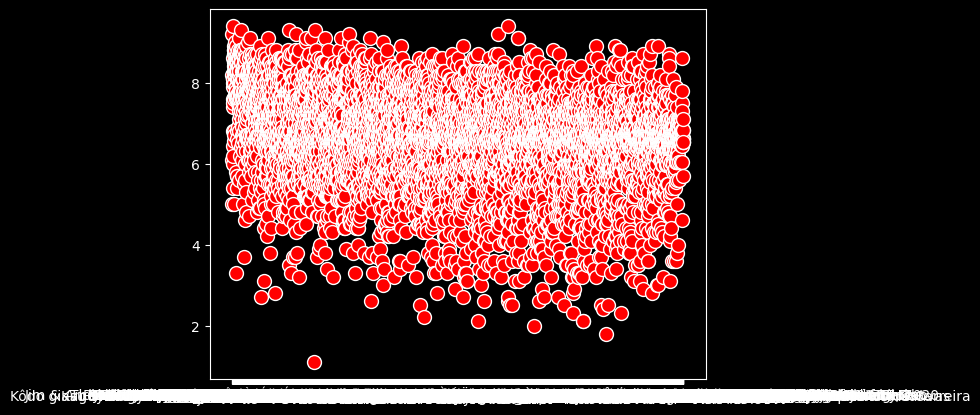

In [20]:
plt.style.use('dark_background')  # Apply a dark theme
plt.scatter(df["MOVIES"], df["RATING"], c='red', marker='o', edgecolors='white', s=100)


Well that sure took its time to draw this. What if we had used C# instead? Let's try that.
I am going to use XPlot for visualization in C#.

In [21]:
// matplotlib is good but lets try C# instead. it's shockingly faste!r
#r "nuget: XPlot.Plotly"
#r "nuget: XPlot.Plotly.Interactive"

Installed Packages XPlot.Plotly, 4.0.6 XPlot.Plotly.Interactive, 4.0.7

Loading extensions from `C:\Users\Qutub Uddin\.nuget\packages\xplot.plotly.interactive\4.0.7\interactive-extensions\dotnet\XPlot.Plotly.Interactive.dll`

Configuring PowerShell Kernel for XPlot.Plotly integration.

Installed support for XPlot.Plotly.

In [22]:
using XPlot.Plotly;

Let's draw a scatter plot between `RATING` and `VOTES`

In [23]:
var chart = Chart.Plot(
    new Scattergl() // remove Graph.
    {
        x = movie_records.Select(x => x.VOTES),
        y = movie_records.Select(x => x.RATING),
        mode = "markers",
        marker = new () // remove Graph.
        {
            color = "red",
            size = 10,
            line = new () {color = "white",width=1}
        }
    }
);
chart.WithLayout(new()
        {
            title = "Scatter Plot Rating and Votes",
            paper_bgcolor = "rgba(0, 0, 0, 0)",
            plot_bgcolor = "rgba(0, 0, 0, 0)",
            font = new() { color = "white" },
            xaxis = new() { title = "Votes" },
            yaxis = new() { title = "Rating" },
        });
chart

<!DOCTYPE html>

WoW now thats fast. Not only that the visual is also reactive!.

Now let's move on to some other visueals. a heat map between `RATING` and `VOTES` correlation

In [24]:
correlation_matrix = df[["RATING","VOTES"]].corr()
correlation_matrix

,RATING,VOTES
RATING,1.000000,0.191387
VOTES,0.191387,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

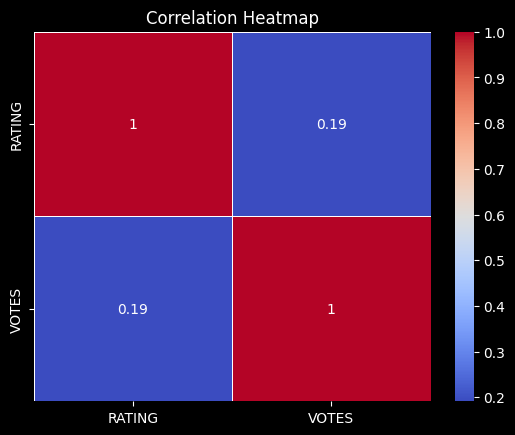

In [25]:

plt.style.use('dark_background')  # Apply a dark 
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")


Now let's draw a Bar chart between `GENRE` and `MOVIES` count/

In [26]:
from sklearn.preprocessing import MultiLabelBinarizer

`GENRE` is an list of string. Let's convert it to columns and sum them all up.

In [30]:
gdf = df[df["GENRE"].isnull() == False]
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(gdf['GENRE'])
genre_encoded_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

gdf = pd.concat([gdf, genre_encoded_df], axis=1)
genre_counts = gdf.iloc[:, 10:].sum().sort_values(ascending=False)

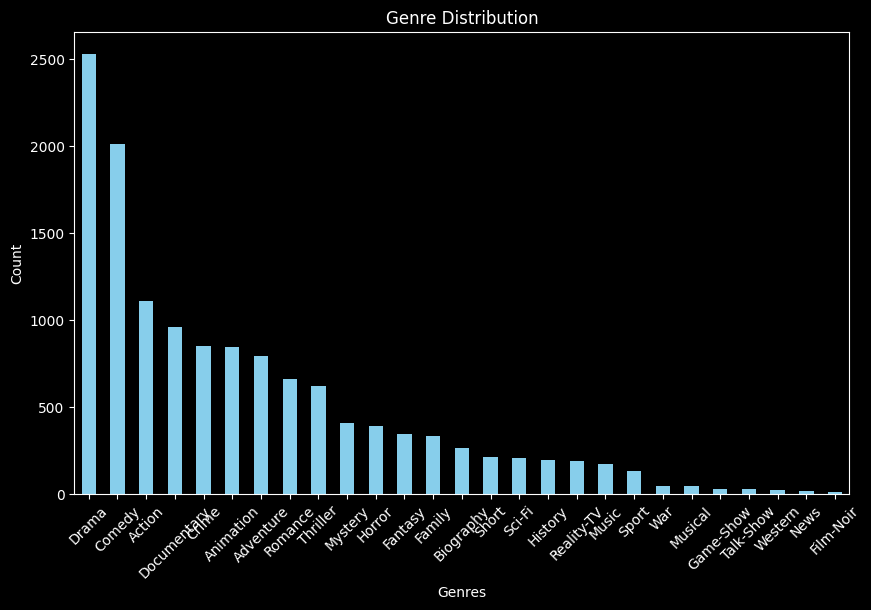

In [31]:
plt.style.use('dark_background')  # Apply a dark 
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Genre Distribution')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Let's do another bar chart between `GENRE` and Average `RATING` but this time using C#.

In [32]:
// Create a bar chart

var genre_rating_distro = 
(from m in movie_records
where m.GENRE is not null
from genre in m.GENRE
group m by genre into g
let heat = g.Average(m => m.RATING)
orderby heat descending
select new {Key = g.Key, Heat = heat}
).ToList();

var chart = Chart.Plot(new Bar
{
x = genre_rating_distro.Select(x => x.Key),
y = genre_rating_distro.Select(x => x.Heat),
marker = new() { color = "skyblue" } // Bar color
});

chart.WithLayout(new ()
{
title = "Genre and Rating Distribution",
xaxis = new () { title = "Genre", tickangle = -45},
yaxis = new () { title = "Avg Rating" },
paper_bgcolor = "rgba(0, 0, 0, 0)", // Transparent background
plot_bgcolor = "rgba(0, 0, 0, 0)", // Transparent plot area
font = new ()
    {
        color = "white" // Text color
    },
});

// Display the chart in the default web browser
chart

<!DOCTYPE html>